# Combined E2E analysis
This notebook relies on the condensed, pickle format of the data that has been saved out by the notebooks `iperf_data_loading` and `mcd_data_loading`

In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data loading
Import the data from the other notebooks

In [178]:
import pickle

def load_iperf_data(dev):
    return pickle.load(open('%s_iperf.pickle' % dev, 'rb'))

def load_mcd_data(dev):
    return pickle.load(open("%s_mcd.pickle" % dev, "rb"))

def load_power_data(dev):
    return pickle.load(open("%s_powers.pickle" % dev, "rb"))

def load_device_data(dev):
    print("Loading "+dev)
    return load_iperf_data(dev), load_mcd_data(dev), load_power_data(dev)

In [179]:
arista_throughput, (arista_latency, arista_success), arista_powers = load_device_data('arista')
fpga_throughput, (fpga_latency, fpga_success), fpga_powers = load_device_data('fpga')
tofino_throughput, (tofino_latency, tofino_success), tofino_powers = load_device_data('tofino')
cpu_throughput, cpu_powers = load_iperf_data('cpu'), load_power_data('cpu')

Loading arista
Loading fpga
Loading tofino


In [95]:
FPGA_DEVICES = set([
    'tofino', 'fpga12/0', 'fpga12/1', 'fpga12/2', 'fpga13/0', 'fpga13/1'
])
TOFINO_DEVICES = set([
    'tofino', 'fpga12/0', 'fpga12/1', 'fpga12/2'
])
ARISTA_DEVICES = set([
    'arista', 'fpga12/0', 'fpga12/1', 'fpga12/2', 'fpga13/0', 'fpga13/1'
])
CPU_DEVICES = set([
    'arista', 'tclust2', 'tclust4'
])
EXPERIMENT_DEVICES = [
    set(['arista', 'tofino']),
    set(['fpga13/0', 'fpga13/1', 'tclust2', 'tclust4']),
    set([]),
    set(['fpga12/1', 'fpga12/2']),
    set(['fpga12/0'])
]
EXPERIMENTS = [
    'baseline', 'hc', 'drop', 'fec', 'kv'
]

def filter_experiment_devices(df, dev_list):
    all_dfs = []
    all_devs = set()
    for experiment, exp_devs in zip(EXPERIMENTS, EXPERIMENT_DEVICES):
        all_devs |= exp_devs
        all_devs &= dev_list
        all_dfs.append(df[(df.experiment == experiment) & (df.device.isin(all_devs))])
    return pd.concat(all_dfs, ignore_index=True)
        
def get_power_summary(df, dev_list):
    x = filter_experiment_devices(df, dev_list)
    x = x.assign(epoch = (x.exp_time).round(0))
    group = x.groupby(['epoch', 'device', 'experiment', 'trial'])
    means = group.mean()
    
    dfs = []
    for exp, exp_group in means.groupby('experiment', group_keys=True):
        dev_groups = exp_group.groupby(['epoch', 'trial'])
        summed = dev_groups.sum()
        counts = dev_groups.power.count()
        summed.exp_time /= counts
        summed = summed.assign(experiment = exp)
        dfs.append(summed[counts == max(counts)])

    return pd.concat(dfs, ignore_index=True)

def get_within_trial_power_summary(df, dev_list):
    x = filter_experiment_devices(df, dev_list)
    x = x.assign(epoch = (x.exp_time).round(0))
    group = x.groupby(['epoch', 'device', 'experiment', 'trial'])
    means = group.mean()
    
    dfs = []
    for (exp, trial), exp_group in means.groupby(['experiment', 'trial']):
        dev_groups = exp_group.groupby(['epoch'])
        summed = dev_groups.sum()
        counts = dev_groups.power.count()
        summed.exp_time /= counts
        summed = summed.assign(experiment = exp, trial=trial)
        dfs.append(summed[counts == max(counts)].reset_index())

    return pd.concat(dfs, ignore_index=True)

In [328]:
from matplotlib import patches

BOX_WIDTH = .25
EXPERIMENTS = ['baseline', 'hc', 'drop', 'fec', 'kv']
BOXPLOT_ARGS = dict(
    showfliers=False,
    patch_artist=True,
    whis=[10, 90],
    whiskerprops=dict(linewidth=2)
)

def boxplot(df, offset=0, color=None, fmt='-', no_xtick=False,
            group_col='experiment', plot_col='value', 
            width=BOX_WIDTH, groups=EXPERIMENTS, **plot_kwargs):
    
    datas = []
    
    for group_name in groups:
        group = df[df[group_col] == group_name]
        datas.append(group[plot_col])
        
    x = np.arange(len(groups)) + offset
    medians = [np.median(d) for d in datas]
    
    pl = plt.plot(x, medians, fmt, color=color, **plot_kwargs)
    bp = plt.boxplot(datas, positions=x, widths=width,
                     boxprops=dict(facecolor=color),
                     **BOXPLOT_ARGS)
    
    if not no_xtick:
        plt.gca().set_xticks(np.arange(len(groups)))
        plt.gca().set_xticklabels(groups, fontsize=14)
        for label in plt.gca().get_xticklabels():
            if label.get_text().lower() == 'drop':
                label.set_color('red')
    else:
        plt.gca().set_xticks([])
        
    return pl

MCD_LIMS = 7, 37        
        
def mcd_boxplot(mcd_data, **kwargs):
    mcd_data = mcd_data[(mcd_data.time > MCD_LIMS[0]) & (mcd_data.time < MCD_LIMS[1])]
    g = boxplot(mcd_data[mcd_data.type == 'get'], -.2, 'green',  **kwargs)
    s = boxplot(mcd_data[mcd_data.type == 'set'], .2, 'blue', linestyle='--', **kwargs)
    return g+s


LEGEND_OPTS = {'loc': 'center left',
               'bbox_to_anchor': (1, .5),
               'fancybox': True,
               'shadow': True}

IPERF_LIMS = 2, 32        

def iperf_boxplot(data1, data2, **kwargs):
    data1 = data1[(data1.time > IPERF_LIMS[0]) & (data1.time < IPERF_LIMS[1])]
    data2 = data2[(data2.time > IPERF_LIMS[0]) & (data2.time < IPERF_LIMS[1])]
    
    a = boxplot(data1, -.2, 'red',  **kwargs)
    b = boxplot(data2, .2, 'maroon', linestyle='--',**kwargs)
    return a+b
    
POWER_LIMS = 10, 40    
    
def power_boxplot(tof_pow, fpga_pow, arista_pow, **kwargs):
    tof_pow = tof_pow[(tof_pow.exp_time > POWER_LIMS[0]) & (tof_pow.exp_time < POWER_LIMS[1])]
    fpga_pow = fpga_pow[(fpga_pow.exp_time > POWER_LIMS[0]) & (fpga_pow.exp_time < POWER_LIMS[1])]
    arista_pow = arista_pow[(arista_pow.exp_time > POWER_LIMS[0]) & (arista_pow.exp_time < POWER_LIMS[1])]
    
    tof_pow = get_power_summary(tof_pow, TOFINO_DEVICES)
    fpga_pow = get_power_summary(fpga_pow, FPGA_DEVICES)
    arista_pow = get_power_summary(arista_pow, FPGA_DEVICES)
    
    a = boxplot(tof_pow, -.25, 'red',  plot_col='power', **kwargs)
    b = boxplot(fpga_pow, 0, 'maroon', linestyle='--', plot_col='power', **kwargs)
    c = boxplot(arista_pow, .25, 'orange', linestyle=':', plot_col='power', **kwargs)
    return a+b+c

def e2e_figure(success, latency, tof_tput, fpga_tput, tof_pow, fpga_pow, ari_pow):
    fig, axs = plt.subplots(4, 1, figsize=(5.6, 3.8), sharex=True)

    lat_ax, succ_ax, tput_ax, power_ax = axs
    
    plt.sca(lat_ax)
    latency = latency.assign(value=latency.value * 1e6)
    handles = mcd_boxplot(latency, no_xtick=True)
    plt.yscale('log')
    plt.ylabel('Latency\n(µs)')
    plt.yticks([1e1, 1e2, 1e3])
    lat_ax.legend(handles, ['Get Latency', 'Set Latency'], **LEGEND_OPTS)

    
    plt.sca(succ_ax)
    success = success.assign(value = success.value * 100)
    handles = mcd_boxplot(success, no_xtick=True)
    plt.ylim([92, 101])
    plt.yticks([95, 100])
    plt.ylabel("Success\n(%)")
    succ_ax.legend(handles, ['Get Success', 'Set Success'], **LEGEND_OPTS)

    plt.sca(tput_ax)
    tof_tput = tof_tput.assign(value=tof_tput.value * 1e-3)
    fpga_tput = fpga_tput.assign(value=fpga_tput.value * 1e-3)
    handles = iperf_boxplot(tof_tput, fpga_tput, no_xtick=True)
    plt.ylim([0, 11])
    plt.yticks([5, 10])
    plt.ylabel("Throughput\n(Mbps)")
    tput_ax.legend(handles, ['Tofino HC ', 'FPGA HC'], **LEGEND_OPTS)
    
    plt.sca(power_ax)
    handles = power_boxplot(tof_pow, fpga_pow, ari_pow)
    
    plt.ylabel("Power Use\n(Watts)")
    power_ax.legend(handles, ['Tofino Power', 'FPGA Power', 'Arista Power'], **LEGEND_OPTS)
    
    
    for ax in axs:
        for x in .5, 1.5, 2.5, 3.5:
            ax.axvline(x, color=[.2,.2,.2], linewidth=.5)
        ylims = ax.get_ylim()
        ax.add_patch(patches.Rectangle([1.5, ylims[0]], 1, ylims[1] - ylims[0], 
                                       fill=False, hatch='///', color='r', alpha=.2, linewidth=2))
    
    plt.subplots_adjust(top=.94, bottom=.1, left=0.18, right=.73, hspace=.1)
    plt.xlim([-.5, 4.5])
    return fig

<IPython.core.display.Javascript object>


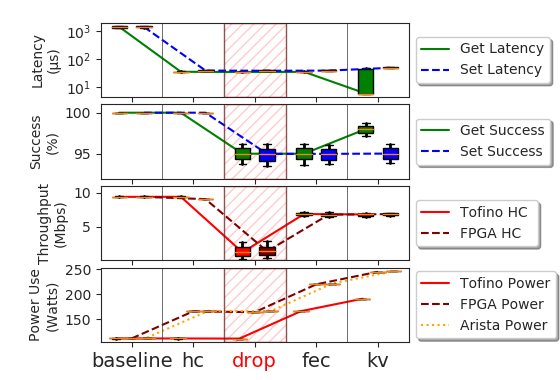

In [329]:
fig = e2e_figure(tofino_success, tofino_latency, tofino_throughput, fpga_throughput, tofino_powers, fpga_powers, arista_powers)

<IPython.core.display.Javascript object>


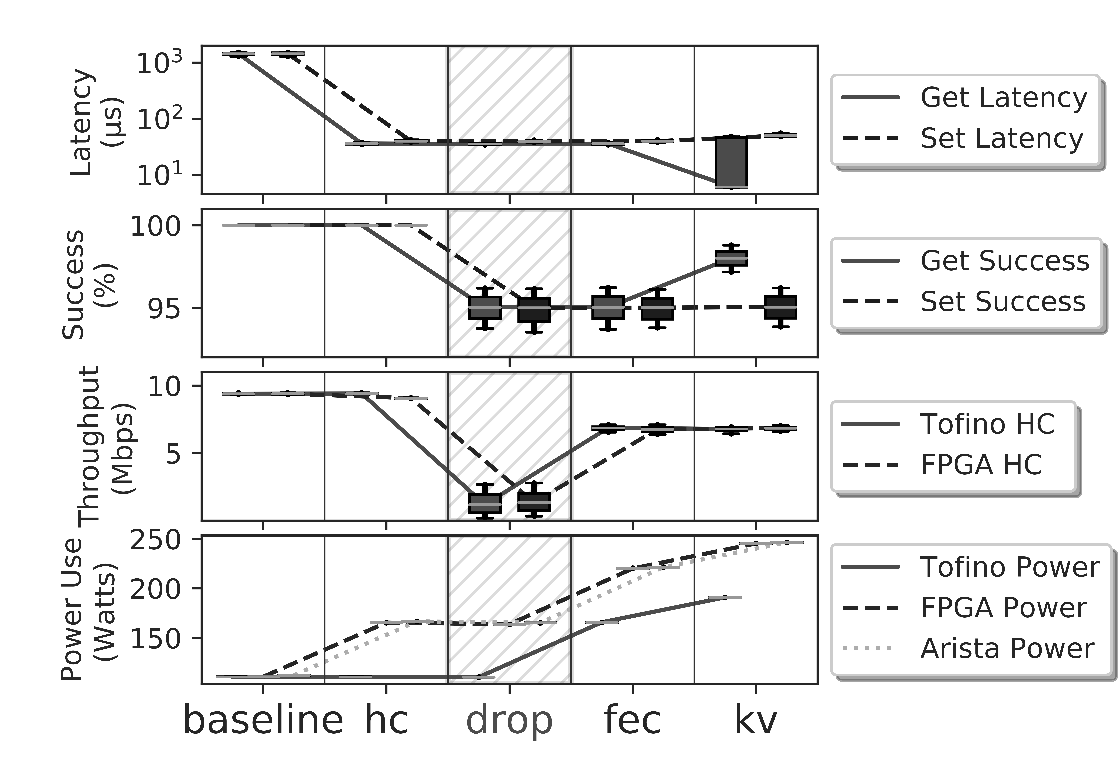

In [330]:
to_gscale(fig)

In [249]:
def plot_timeseries(df, experiment, time_column='time', value_column='value', *args, **kwargs):
    df = df[df.experiment == experiment]
#     dfs = []
# #     for trial, tdf in df.groupby('trial'):
# #         tdf = tdf.sort_values(time_column)
# #         tdf[time_column] = pd.to_timedelta(tdf[time_column], 's')
# #         tdf = tdf.rolling(pd.Timedelta(1, 's'), on=time_column)[[time_column, value_column]].mean()
# #         tdf[time_column] = tdf[time_column].apply(lambda x: x.total_seconds())
# #         dfs.append(tdf.assign(trial=trial))
        
#     df = pd.concat(dfs, ignore_index=True)
    df = df.assign(**{time_column: df[time_column] - df[time_column].min()})
    df = df[df[time_column] < 30]
    counts = df.groupby(time_column).count().reset_index()[value_column]
    max_df = df.groupby(time_column).max().reset_index()[counts > 1]
    min_df = df.groupby(time_column).min().reset_index()[counts > 1]
    median_df = df.groupby(time_column).median().reset_index()[counts > 1]
    
    plt.fill_between(max_df[time_column], min_df[value_column], max_df[value_column], ls='-', edgecolor='face', alpha=.2)
    return plt.plot(median_df[time_column], median_df[value_column], *args, linewidth=1, **kwargs)
    
def plot_throughput_timeseries(df, experiment, *args, **kwargs):
    df = df.assign(value=df.value * 1e-3)
    return plot_timeseries(df, experiment, 'time', 'value', *args, **kwargs)
    
def plot_power_timeseries(df, experiment, devices, *args, **kwargs):
    df = df[df.trial <= 5]
    df = df[(df.exp_time > 8) & (df.exp_time < 38)]
    df = get_within_trial_power_summary(df, devices)
    return plot_timeseries(df, experiment, 'epoch', 'power', *args, **kwargs)


In [256]:
import seaborn as sns
sns.set_style("ticks")

<IPython.core.display.Javascript object>


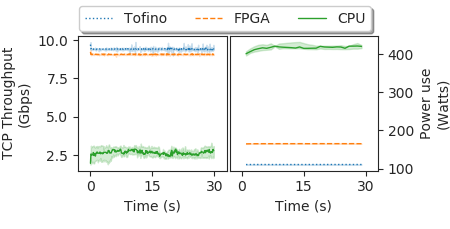

In [332]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4.5, 2.3), sharex=True)
plt.sca(ax1)
plot_throughput_timeseries(tofino_throughput, 'hc', ':')
plot_throughput_timeseries(fpga_throughput, 'hc', '--')
plot_throughput_timeseries(cpu_throughput, 'hc')
ax1.set_ylabel("TCP Throughput\n(Gbps)")
ax1.set_xlabel("Time (s)")

plt.sca(ax2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

t = plot_power_timeseries(tofino_powers, 'hc', TOFINO_DEVICES, ':')
f = plot_power_timeseries(fpga_powers, 'hc', FPGA_DEVICES, '--')
c = plot_power_timeseries(cpu_powers, 'hc', CPU_DEVICES)
ax2.set_ylabel("Power use\n(Watts)")
ax2.set_xlabel("Time (s)")
ax2.set_xticks([0, 15, 30])
plt.xlim([-3, 33])
plt.sca(ax1)
plt.tight_layout()

plt.figlegend(t+f+c, ['Tofino', 'FPGA', 'CPU'],
           loc='upper center', fancybox=True , ncol=3, shadow=True)
plt.subplots_adjust(top=.84, wspace=.02, right=.84)

<IPython.core.display.Javascript object>


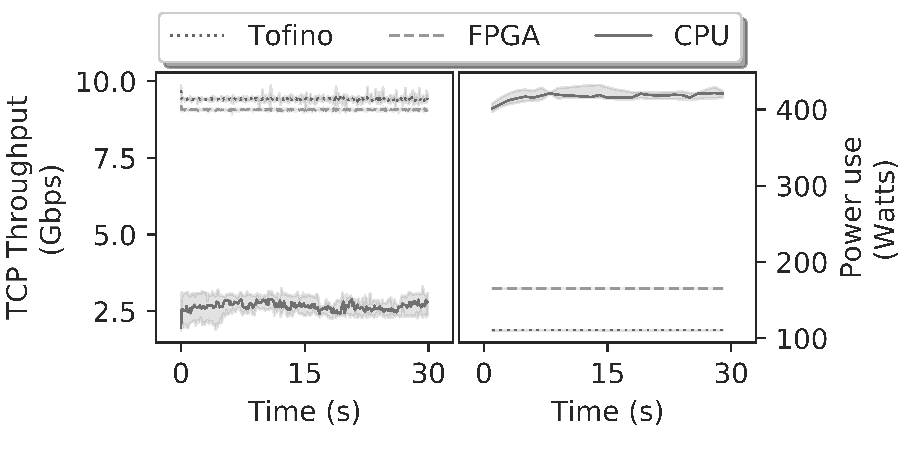

In [333]:
import matplotlib.image as mpimg
import numpy as np

def to_gscale(fig):
    fig.savefig('tmp.png', dpi=1800)
    plt.figure(figsize=(fig.get_figwidth()*2, fig.get_figheight()*2))
    img = mpimg.imread('tmp.png')
    grey = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    plt.imshow(grey, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.axis('off')
    plt.subplots_adjust(top=1, bottom=0, left=0, right=1)

img = to_gscale(fig)